In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

--2024-11-19 09:16:52--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: 'PennFudanPed.zip'

PennFudanPed.zip    100%[===================>]  51.23M  3.53MB/s    in 3m 9s   

2024-11-19 09:20:01 (277 KB/s) - 'PennFudanPed.zip' saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotatio

In [ ]:
import os
import json
import torch
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)[1:]
        masks = mask == obj_ids[:, None, None]
        boxes = []
        for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset("PennFudanPed")
img, target = dataset[0]
print("Image Shape:", np.array(img).shape)
print("Bounding Boxes:", target["boxes"])

Image Shape: (536, 559, 3)
Bounding Boxes: tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]])


In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 195MB/s]  


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = [F.to_tensor(img) for img in images]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {losses.item()}")

Epoch 1, Loss: 1.2354170083999634
Epoch 1, Loss: 0.6630864143371582
Epoch 1, Loss: 0.4864034950733185
Epoch 1, Loss: 0.6585596799850464
Epoch 1, Loss: 0.4518904387950897
Epoch 1, Loss: 0.5167308449745178
Epoch 1, Loss: 0.5793116092681885
Epoch 1, Loss: 0.3894910216331482
Epoch 1, Loss: 0.47888028621673584
Epoch 1, Loss: 0.5538612604141235
Epoch 1, Loss: 0.4609539210796356
Epoch 1, Loss: 0.21564960479736328
Epoch 1, Loss: 0.2481590211391449
Epoch 1, Loss: 0.5603093504905701
Epoch 1, Loss: 0.25316524505615234
Epoch 1, Loss: 0.2096865177154541
Epoch 1, Loss: 0.38506221771240234
Epoch 1, Loss: 0.14580728113651276
Epoch 1, Loss: 0.11235398799180984
Epoch 1, Loss: 0.2050958275794983
Epoch 1, Loss: 0.1986997276544571
Epoch 1, Loss: 0.1766623556613922
Epoch 1, Loss: 0.1389549821615219
Epoch 1, Loss: 0.17328153550624847
Epoch 1, Loss: 0.17548666894435883
Epoch 1, Loss: 0.22232477366924286
Epoch 1, Loss: 0.31486210227012634
Epoch 1, Loss: 0.11826998740434647
Epoch 1, Loss: 0.24384112656116486
Ep

In [ ]:
test_img, _ = dataset[5]
model.eval()
with torch.no_grad():
    prediction = model([F.to_tensor(test_img)])

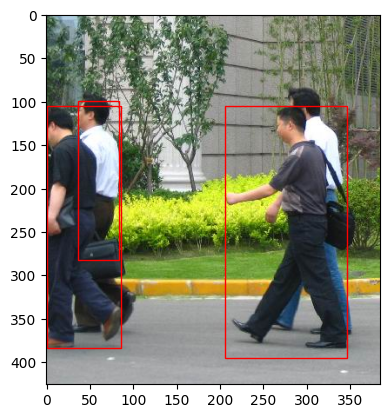

In [ ]:
def plot_image_with_boxes(image, boxes):
    plt.imshow(image)
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor='r', facecolor='none'))
    plt.show()

plot_image_with_boxes(test_img, prediction[0]['boxes'].cpu())